In [1]:
import kagglehub

path = kagglehub.dataset_download("nuranfarhanaprova/processed-rice-varieties-of-bangladesh")

print("Path to dataset files:", path)

100%|██████████| 240M/240M [00:11<00:00, 21.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1


Aush: Attempting RGBe to RGB conversion.
BR-28: Attempting RGBe to RGB conversion.
BR-29: Attempting RGBe to RGB conversion.
Beroi: Attempting RGBe to RGB conversion.
Chinigura: Attempting RGBe to RGB conversion.
Ghee Bhog: Attempting RGBe to RGB conversion.
Katari Najir: Attempting RGBe to RGB conversion.
Katari Siddho: Attempting RGBe to RGB conversion.
Miniket: Attempting RGBe to RGB conversion.
Swarna: Attempting RGBe to RGB conversion.


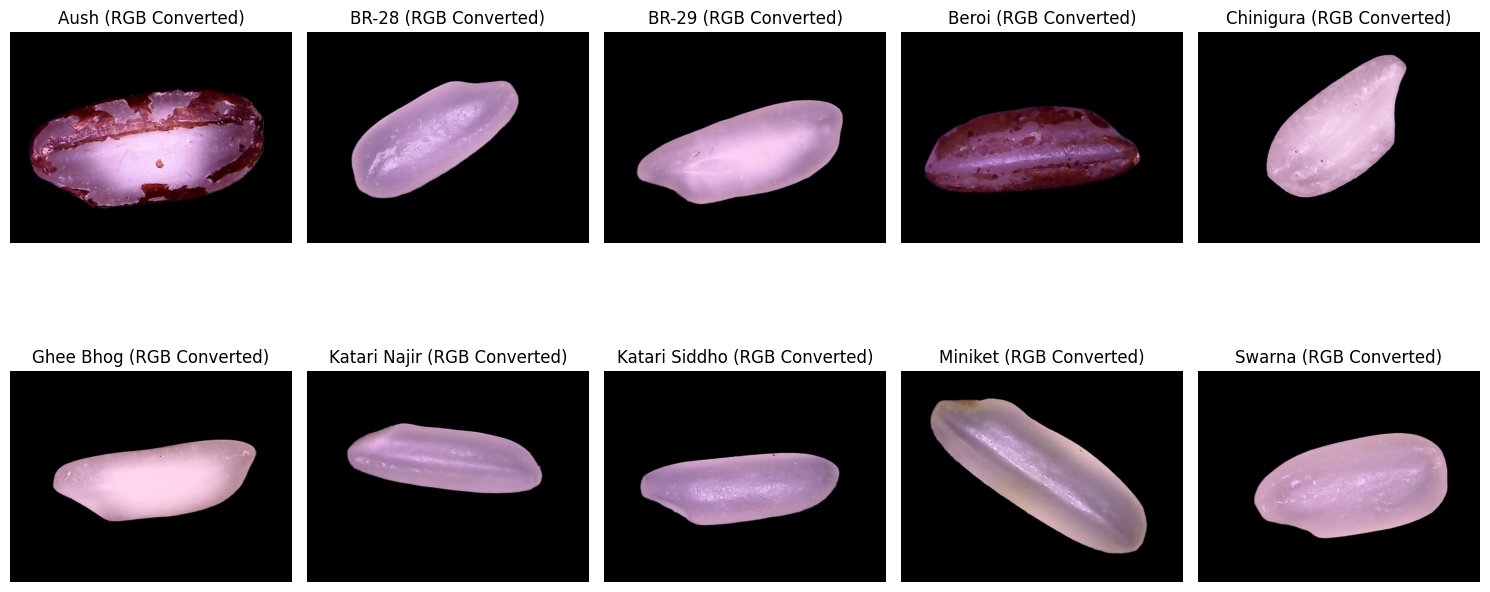

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# ---------- Function: RGBe → RGB (smooth, non-binary) ----------
def rgbe_to_rgb(img):
    """Converts a 4-channel RGBe image to smooth RGB (0-255)."""
    if img is None or img.ndim != 3 or img.shape[2] != 4:
        print("Warning: Input is not a valid 4-channel image for RGBe conversion.")
        return None

    r, g, b, e = cv2.split(img.astype(np.float32))
    scale = np.exp2(e - 128.0)
    rgb = np.stack([(r / 255) * scale, (g / 255) * scale, (b / 255) * scale], axis=-1)

    # Normalize to 0-255 without binary mapping
    rgb_min, rgb_max = rgb.min(), rgb.max()
    if rgb_max - rgb_min > 0:
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    else:
        rgb = np.zeros_like(rgb)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

# ---------- Folder paths ----------
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"

if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory not found at {dataset_dir}. Please ensure the dataset is downloaded and extracted correctly.")
else:
    classes = sorted(os.listdir(dataset_dir))

    plt.figure(figsize=(15, 8))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_dir, cls)

        if not os.path.isdir(class_path):
            print(f"Skipping {cls}: Not a directory.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"{cls}: No image files found, skipping.")
            continue

        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        img_to_display = None
        title_text = cls

        if img is not None and isinstance(img, np.ndarray):
            if img.ndim == 3:  # Color images
                if img.shape[2] == 4:  # RGBe
                    print(f"{cls}: Attempting RGBe to RGB conversion.")
                    img_rgb = rgbe_to_rgb(img)
                    if img_rgb is not None:
                        img_to_display = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
                        title_text += " (RGB Converted)"
                    else:
                        print(f"{cls}: Failed RGBe to RGB conversion.")
                elif img.shape[2] == 3:  # Normal RGB
                    print(f"{cls}: Normal RGB image, using directly.")
                    img_to_display = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
                    title_text += " (Original RGB)"
                else:
                    print(f"{cls}: Unsupported number of channels ({img.shape[2]}), skipping.")
            elif img.ndim == 2:  # Grayscale
                print(f"{cls}: Grayscale image, skipping for visualization.")
            else:
                print(f"{cls}: Unsupported number of dimensions ({img.ndim}), skipping.")
        else:
            print(f"{cls}: Could not load image at {img_path} or it is not a valid numpy array, skipping.")

        # Plotting
        plt.subplot(2, (len(classes) + 1) // 2, i + 1)
        if img_to_display is not None:
            plt.imshow(img_to_display)
            plt.title(title_text)
        else:
            plt.text(0.5, 0.5, "Image Skipped", horizontalalignment='center', verticalalignment='center')
            plt.title(title_text + " (Skipped)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [3]:
import os
import shutil
import numpy as np

# -----------------------------
# Paths
# -----------------------------
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
split_base_dir = '/kaggle/working/split_data_80_20'

# -----------------------------
# Prepare directories
# -----------------------------
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
splits = ['train', 'val', 'test']

# Clear previous split (optional safety step)
if os.path.exists(split_base_dir):
    shutil.rmtree(split_base_dir)

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# -----------------------------
# Perform split
# -----------------------------
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = sorted(os.listdir(class_dir))
    np.random.shuffle(images)

    total = len(images)

    # Step 1: 80:20 train:test
    train_val_end = int(total * 0.8)
    train_val_images = images[:train_val_end]
    test_images = images[train_val_end:]

    # Step 2: Within training portion, 10% for validation
    val_end = int(len(train_val_images) * 0.1)
    val_images = train_val_images[:val_end]
    train_images = train_val_images[val_end:]

    # Mapping
    split_images = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }

    # Copy images
    for split in splits:
        for img_name in split_images[split]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_base_dir, split, cls, img_name)
            shutil.copy(src, dst)

# -----------------------------
# Print split summary
# -----------------------------
print(" Dataset Split Summary (number of images per class):\n")
for split in splits:
    print(f"--- {split.upper()} ---")
    for cls in classes:
        split_cls_dir = os.path.join(split_base_dir, split, cls)
        count = len(os.listdir(split_cls_dir))
        print(f"{cls}: {count}")
    print()


 Dataset Split Summary (number of images per class):

--- TRAIN ---
Aush: 144
BR-28: 144
BR-29: 144
Miniket: 144
Swarna: 144
Katari Najir: 144
Ghee Bhog: 144
Chinigura: 144
Katari Siddho: 144
Beroi: 144

--- VAL ---
Aush: 16
BR-28: 16
BR-29: 16
Miniket: 16
Swarna: 16
Katari Najir: 16
Ghee Bhog: 16
Chinigura: 16
Katari Siddho: 16
Beroi: 16

--- TEST ---
Aush: 40
BR-28: 40
BR-29: 40
Miniket: 40
Swarna: 40
Katari Najir: 40
Ghee Bhog: 40
Chinigura: 40
Katari Siddho: 40
Beroi: 40



Found 1440 images belonging to 10 classes.
Found 160 images belonging to 10 classes.
Found 400 images belonging to 10 classes.
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
45/45 - 80s - 2s/step - accuracy: 0.5896 - loss: 1.2118 - val_accuracy: 0.7625 - val_loss: 0.7617 - learning_rate: 1.0000e-03
Epoch 2/40
45/45 - 14s - 301ms/step - accuracy: 0.7701 - loss: 0.7191 - val_accuracy: 0.8188 - val_loss: 0.6178 - learning_rate: 1.0000e-03
Epoch 3/40
45/45 - 14s - 301ms/step - accuracy: 0.8090 - loss: 0.5746 - val_accuracy: 0.8438 - val_loss: 0.5503 - learning_rate: 1.0000e-03
Epoch 4/40
45/45 - 13s - 297ms/step - accuracy: 0.8639 - loss: 0.4734 - val_accuracy: 0.8562 - val_loss: 0.4964 - learning_rate: 1.0000e-03
Epoch 5/40
45/45 - 14s - 309ms/step - accuracy: 0.8833 - loss: 0.4229 - val_accuracy: 0.8438 - val_loss: 0.5073 - learning_rate: 1.0000e-03
Epoch 6/40
45/45 - 14s - 301ms/step - accuracy: 0.8639 - loss: 0.4327 - val_accuracy: 0.8500 - val_loss: 0.5399 - learning_rate: 1.0000e-03
Epoch 7/40

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
45/45 - 13s - 298ms/step - accuracy: 0.8847 - loss: 0.3806 - val_accuracy: 

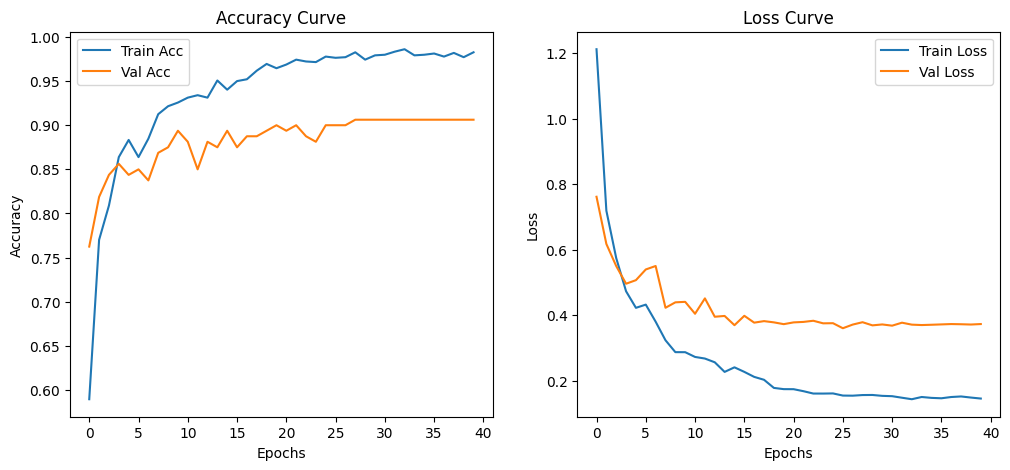


Test Classification Report:
               precision    recall  f1-score   support

         Aush     0.9756    1.0000    0.9877        40
        BR-28     0.8140    0.8750    0.8434        40
        BR-29     0.8857    0.7750    0.8267        40
      Miniket     1.0000    0.9750    0.9873        40
       Swarna     1.0000    0.9750    0.9873        40
 Katari Najir     0.8049    0.8250    0.8148        40
    Ghee Bhog     0.7381    0.7750    0.7561        40
    Chinigura     0.8889    0.8000    0.8421        40
Katari Siddho     0.9512    0.9750    0.9630        40
        Beroi     0.8372    0.9000    0.8675        40

     accuracy                         0.8875       400
    macro avg     0.8896    0.8875    0.8876       400
 weighted avg     0.8896    0.8875    0.8876       400



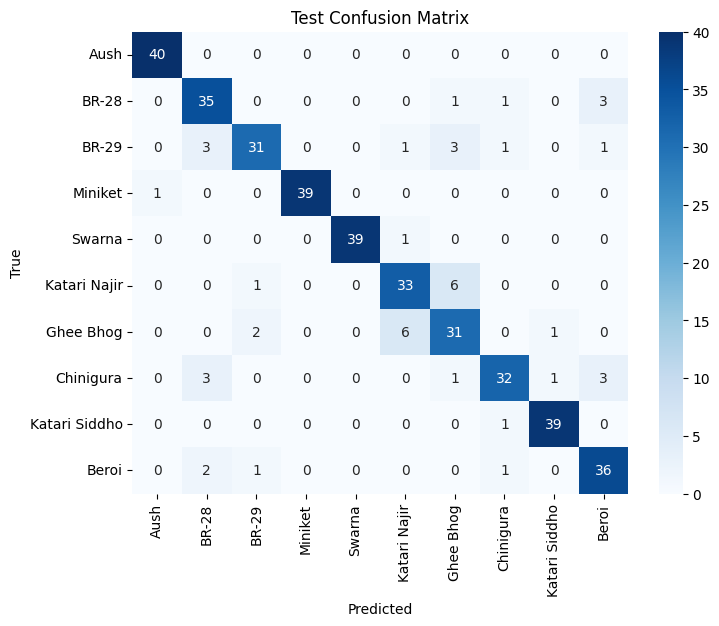

Aush Accuracy: 1.0000
BR-28 Accuracy: 0.8750
BR-29 Accuracy: 0.7750
Miniket Accuracy: 0.9750
Swarna Accuracy: 0.9750
Katari Najir Accuracy: 0.8250
Ghee Bhog Accuracy: 0.7750
Chinigura Accuracy: 0.8000
Katari Siddho Accuracy: 0.9750
Beroi Accuracy: 0.9000
Test AUC: 0.9918
Test PR AUC: 0.9491

Training Time: 614.40 seconds


In [4]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
split_base_dir = '/kaggle/working/split_data_80_20'
img_size = (224, 224)
batch_size = 32
num_classes = len([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: NASNetMobile
# -----------------------------
def build_nasnetmobile_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

nasnet_model = build_nasnetmobile_model(num_classes=num_classes)
nasnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback (only ReduceLROnPlateau)
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = nasnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, nasnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, nasnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, nasnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")


In [5]:
start_test = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.114102 seconds


In [6]:
# Calculate and print the number of parameters
total_params = nasnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 4,816,030
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Macro Precision: 0.8896
Macro Recall: 0.8875
Macro F1-score: 0.8876
Aush: Precision=0.9756, Recall=1.0000, F1=0.9877
BR-28: Precision=0.8140, Recall=0.8750, F1=0.8434
BR-29: Precision=0.8857, Recall=0.7750, F1=0.8267
Miniket: Precision=1.0000, Recall=0.9750, F1=0.9873
Swarna: Precision=1.0000, Recall=0.9750, F1=0.9873
Katari Najir: Precision=0.8049, Recall=0.8250, F1=0.8148
Ghee Bhog: Precision=0.7381, Recall=0.7750, F1=0.7561
Chinigura: Precision=0.8889, Recall=0.8000, F1=0.8421
Katari Siddho: Precision=0.9512, Recall=0.9750, F1=0.9630
Beroi: Precision=0.8372, Recall=0.9000, F1=0.8675


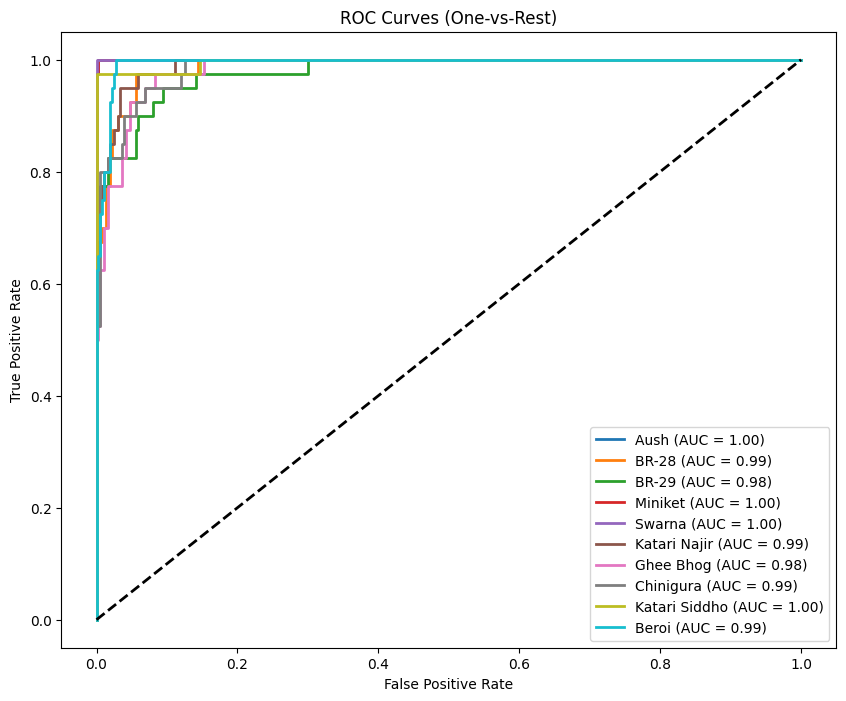

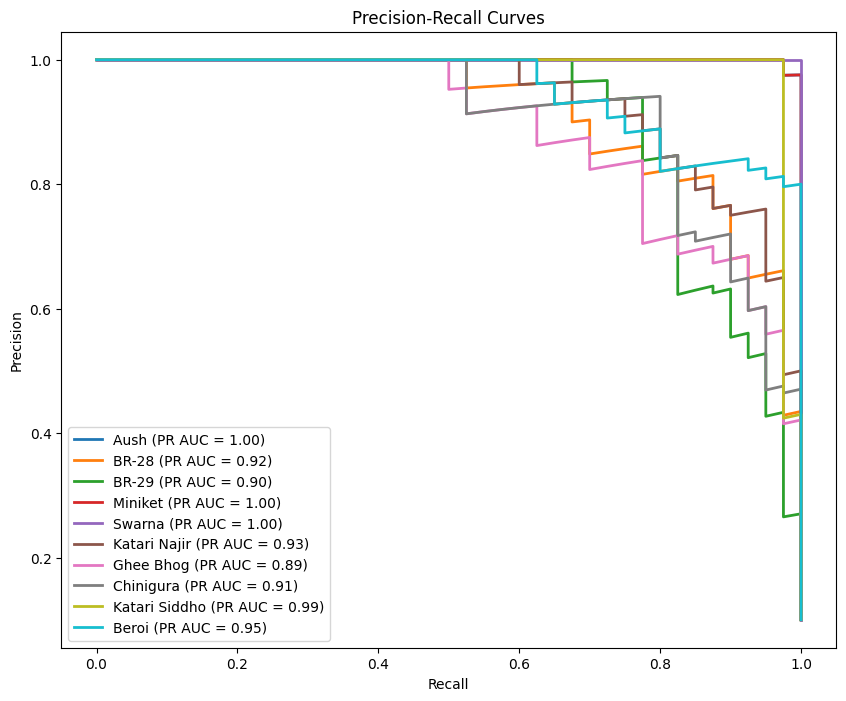

Total inference time: 4.21 sec
Inference time per sample: 0.010522 sec

Most confused class pairs:
Aush is most often confused with Aush (0 samples)
BR-28 is most often confused with Beroi (3 samples)
BR-29 is most often confused with BR-28 (3 samples)
Miniket is most often confused with Aush (1 samples)
Swarna is most often confused with Katari Najir (1 samples)
Katari Najir is most often confused with Ghee Bhog (6 samples)
Ghee Bhog is most often confused with Katari Najir (6 samples)
Chinigura is most often confused with BR-28 (3 samples)
Katari Siddho is most often confused with Chinigura (1 samples)
Beroi is most often confused with BR-28 (2 samples)


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

Found 1440 images belonging to 10 classes.
Found 160 images belonging to 10 classes.
Found 400 images belonging to 10 classes.
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
45/45 - 36s - 791ms/step - accuracy: 0.2979 - loss: 2.0313 - val_accuracy: 0.5125 - val_loss: 1.5979 - learning_rate: 1.0000e-03
Epoch 2/40
45/45 - 14s - 315ms/step - accuracy: 0.4896 - loss: 1.4663 - val_accuracy: 0.4500 - val_loss: 1.4395 - learning_rate: 1.0000e-03
Epoch 3/40
45/45 - 14s - 322ms/step - accuracy: 0.5590 - loss: 1.2707 - val_accuracy: 0.6062 - val_loss: 1.2777 - learning_rate: 1.0000e-03
Epoch 4/40
45/45 - 15s - 327ms/step - accuracy: 0.6181 - loss: 1.1121 - val_accuracy: 0.6750 - val_loss: 1.1922 - learning_rate: 1.0000e-03
Epoch 5/40
45/45 - 14s - 321ms/step - accuracy: 0.6299 - loss: 1.0482 - val_accuracy: 0.6438 - val_loss: 1.1812 - learning_rate: 1.0000e-03
Epoch 6/40
45/45 - 14s - 312ms/step - accuracy: 0.6632 - loss: 0.9916 - val_accuracy: 0.5938 - val_loss: 1.1741 - learning_rate: 1.0000e-03
Epoch 7/40
45/45 - 14s - 319ms/step - accuracy: 0.6917 - loss: 0.9433 - val_accuracy: 0.6125 - val_loss: 1.1146 - learning_rate: 1.0000e-03
Epoch 8/40
45/45 - 1

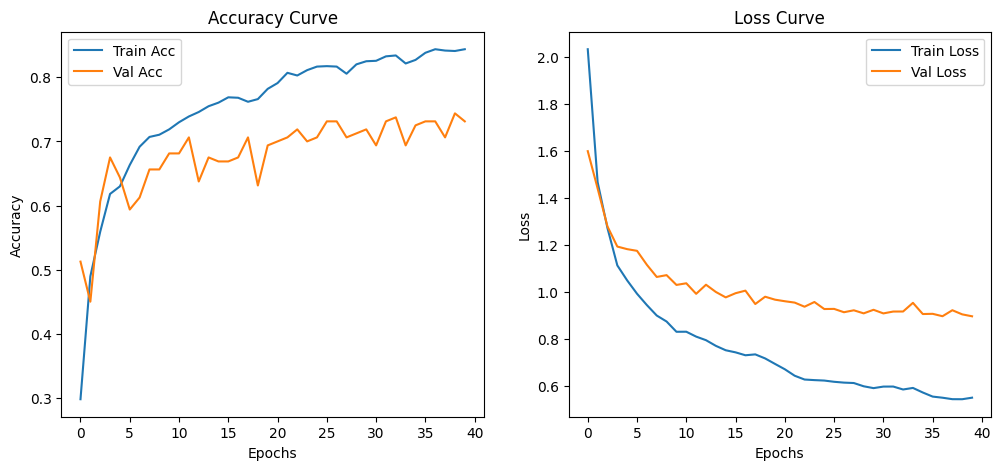


Test Classification Report:
               precision    recall  f1-score   support

         Aush     0.8444    0.9500    0.8941        40
        BR-28     0.8235    0.7000    0.7568        40
        BR-29     0.7353    0.6250    0.6757        40
        Beroi     0.9143    0.8000    0.8533        40
    Chinigura     0.9459    0.8750    0.9091        40
    Ghee Bhog     0.7609    0.8750    0.8140        40
 Katari Najir     0.8286    0.7250    0.7733        40
Katari Siddho     0.7561    0.7750    0.7654        40
      Miniket     0.8444    0.9500    0.8941        40
       Swarna     0.7500    0.9000    0.8182        40

     accuracy                         0.8175       400
    macro avg     0.8203    0.8175    0.8154       400
 weighted avg     0.8203    0.8175    0.8154       400



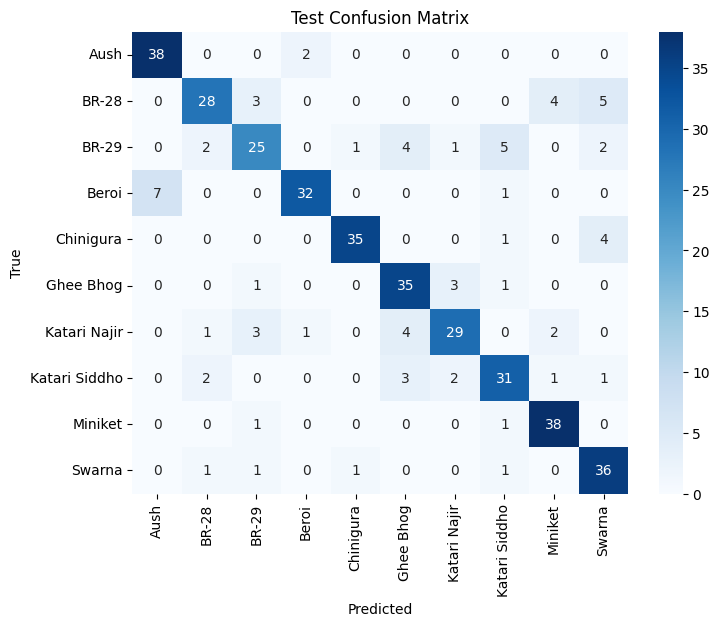

Aush Accuracy: 0.9500
BR-28 Accuracy: 0.7000
BR-29 Accuracy: 0.6250
Beroi Accuracy: 0.8000
Chinigura Accuracy: 0.8750
Ghee Bhog Accuracy: 0.8750
Katari Najir Accuracy: 0.7250
Katari Siddho Accuracy: 0.7750
Miniket Accuracy: 0.9500
Swarna Accuracy: 0.9000
Test AUC: 0.9802
Test PR AUC: 0.8877

Training Time: 595.19 seconds


In [8]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data_80_20'
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: ConvNeXtTiny
# -----------------------------
def build_convnext_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

convnext_model = build_convnext_model(num_classes=num_classes)
convnext_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback (only ReduceLROnPlateau)
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, convnext_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, convnext_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, convnext_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")


In [9]:
start_test = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.052533 seconds


In [10]:
# Calculate and print the number of parameters
total_params = convnext_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 28,218,986
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Macro Precision: 0.8203
Macro Recall: 0.8175
Macro F1-score: 0.8154
Aush: Precision=0.8444, Recall=0.9500, F1=0.8941
BR-28: Precision=0.8235, Recall=0.7000, F1=0.7568
BR-29: Precision=0.7353, Recall=0.6250, F1=0.6757
Beroi: Precision=0.9143, Recall=0.8000, F1=0.8533
Chinigura: Precision=0.9459, Recall=0.8750, F1=0.9091
Ghee Bhog: Precision=0.7609, Recall=0.8750, F1=0.8140
Katari Najir: Precision=0.8286, Recall=0.7250, F1=0.7733
Katari Siddho: Precision=0.7561, Recall=0.7750, F1=0.7654
Miniket: Precision=0.8444, Recall=0.9500, F1=0.8941
Swarna: Precision=0.7500, Recall=0.9000, F1=0.8182


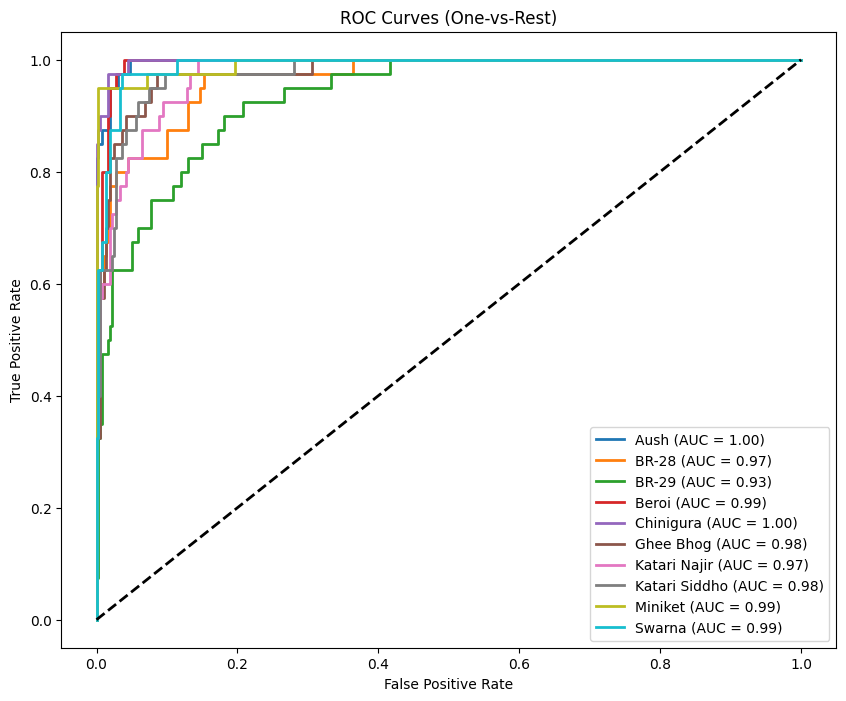

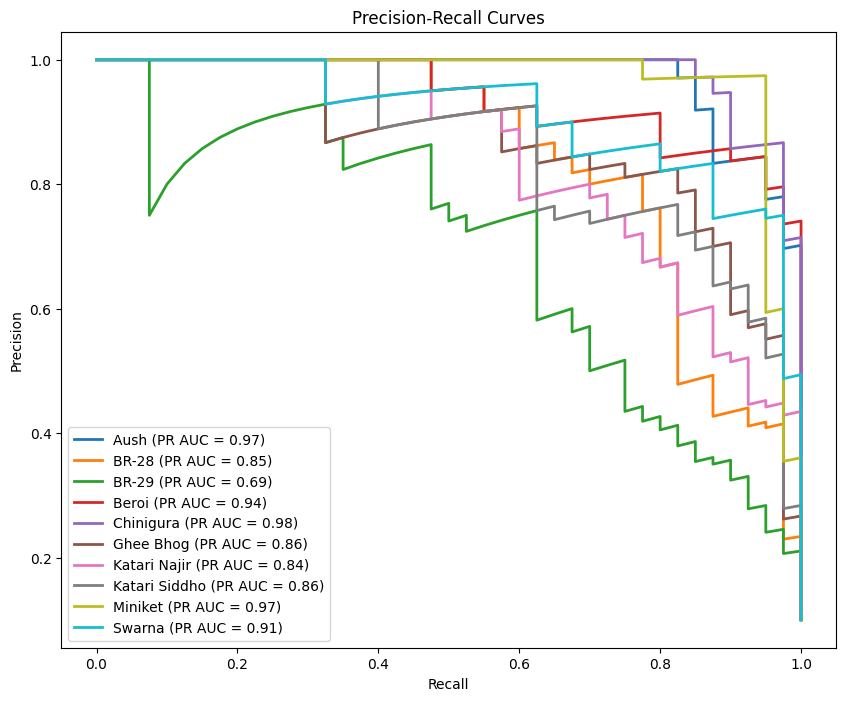

Total inference time: 4.38 sec
Inference time per sample: 0.010961 sec

Most confused class pairs:
Aush is most often confused with Beroi (2 samples)
BR-28 is most often confused with Swarna (5 samples)
BR-29 is most often confused with Katari Siddho (5 samples)
Beroi is most often confused with Aush (7 samples)
Chinigura is most often confused with Swarna (4 samples)
Ghee Bhog is most often confused with Katari Najir (3 samples)
Katari Najir is most often confused with Ghee Bhog (4 samples)
Katari Siddho is most often confused with Ghee Bhog (3 samples)
Miniket is most often confused with BR-29 (1 samples)
Swarna is most often confused with BR-28 (1 samples)


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


Found 1440 images belonging to 10 classes.
Found 160 images belonging to 10 classes.
Found 400 images belonging to 10 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
45/45 - 43s - 949ms/step - accuracy: 0.5910 - loss: 1.2154 - val_accuracy: 0.7937 - val_loss: 0.6570 - learning_rate: 1.0000e-03
Epoch 2/40
45/45 - 15s - 344ms/step - accuracy: 0.8132 - loss: 0.6115 - val_accuracy: 0.8000 - val_loss: 0.5736 - learning_rate: 1.0000e-03
Epoch 3/40
45/45 - 16s - 359ms/step - accuracy: 0.8583 - loss: 0.4652 - val_accuracy: 0.8500 - val_loss: 0.5102 - learning_rate: 1.0000e-03
Epoch 4/40
45/45 - 16s - 345ms/step - accuracy: 0.8653 - loss: 0.4274 - val_accuracy: 0.8875 - val_loss: 0.4714 - learning_rate: 1.0000e-03
Epoch 5/40
45/45 - 15s - 335ms/step - accuracy: 0.9056 - loss: 0.3384 - val_accuracy: 0.8687 - val_loss: 0.4318 - learning_rate: 1.0000e-03
Epoch 6/40
45/45 - 16s - 347ms/step - accuracy: 0.9160 - loss: 0.3154 - val_accuracy: 0.9250 - val_loss: 0.3493 - learning_rate: 1.0000e-03
Epoch 7/40
45/45 - 16s - 360ms/step - accuracy: 0.9132 - loss: 0.3082 - val_accuracy: 0.8500 - val_loss: 0.4688 - learning_rate: 1.0000e-03
Epoch 8/40
45/45 - 1

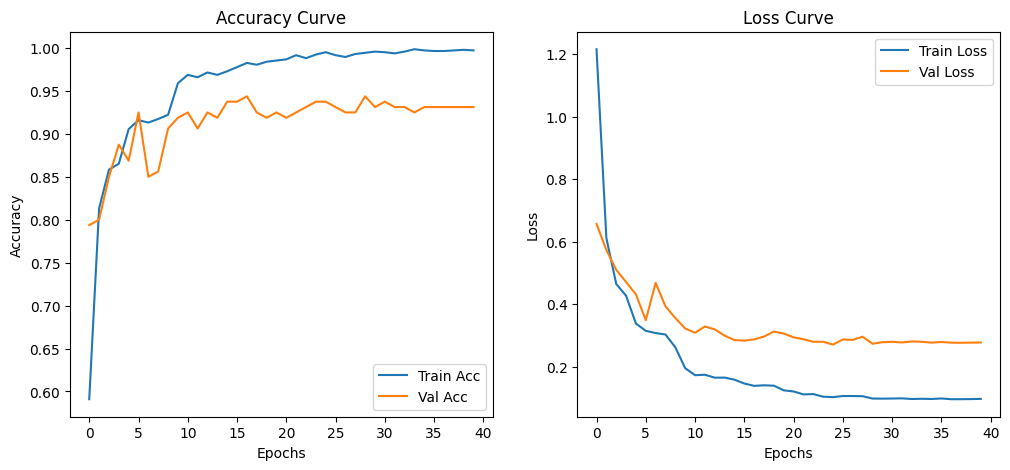


Test Classification Report:
               precision    recall  f1-score   support

         Aush     0.9756    1.0000    0.9877        40
        BR-28     0.8605    0.9250    0.8916        40
        BR-29     0.8947    0.8500    0.8718        40
        Beroi     1.0000    1.0000    1.0000        40
    Chinigura     0.9744    0.9500    0.9620        40
    Ghee Bhog     0.8333    0.8750    0.8537        40
 Katari Najir     0.8049    0.8250    0.8148        40
Katari Siddho     0.9487    0.9250    0.9367        40
      Miniket     1.0000    0.9750    0.9873        40
       Swarna     0.9211    0.8750    0.8974        40

     accuracy                         0.9200       400
    macro avg     0.9213    0.9200    0.9203       400
 weighted avg     0.9213    0.9200    0.9203       400



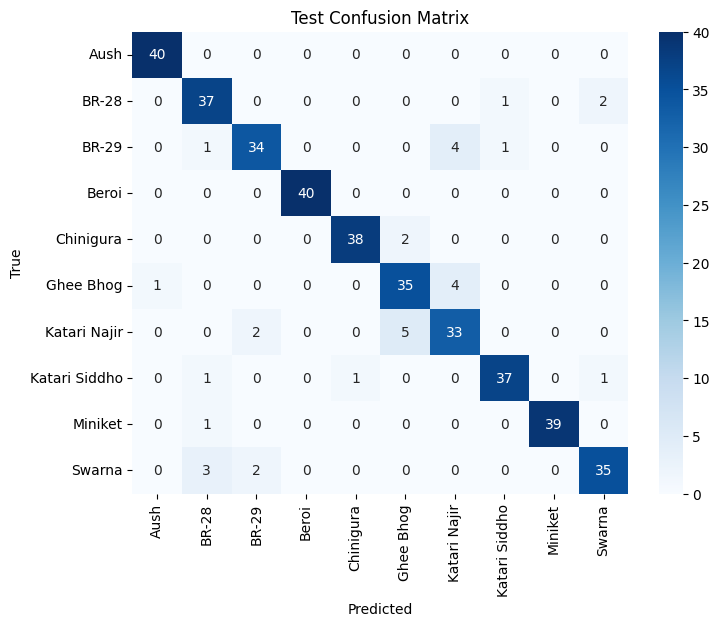

Aush Accuracy: 1.0000
BR-28 Accuracy: 0.9250
BR-29 Accuracy: 0.8500
Beroi Accuracy: 1.0000
Chinigura Accuracy: 0.9500
Ghee Bhog Accuracy: 0.8750
Katari Najir Accuracy: 0.8250
Katari Siddho Accuracy: 0.9250
Miniket Accuracy: 0.9750
Swarna Accuracy: 0.8750
Macro Precision: 0.9213
Macro Recall: 0.9200
Macro F1-score: 0.9203
Aush: Precision=0.9756, Recall=1.0000, F1=0.9877
BR-28: Precision=0.8605, Recall=0.9250, F1=0.8916
BR-29: Precision=0.8947, Recall=0.8500, F1=0.8718
Beroi: Precision=1.0000, Recall=1.0000, F1=1.0000
Chinigura: Precision=0.9744, Recall=0.9500, F1=0.9620
Ghee Bhog: Precision=0.8333, Recall=0.8750, F1=0.8537
Katari Najir: Precision=0.8049, Recall=0.8250, F1=0.8148
Katari Siddho: Precision=0.9487, Recall=0.9250, F1=0.9367
Miniket: Precision=1.0000, Recall=0.9750, F1=0.9873
Swarna: Precision=0.9211, Recall=0.8750, F1=0.8974


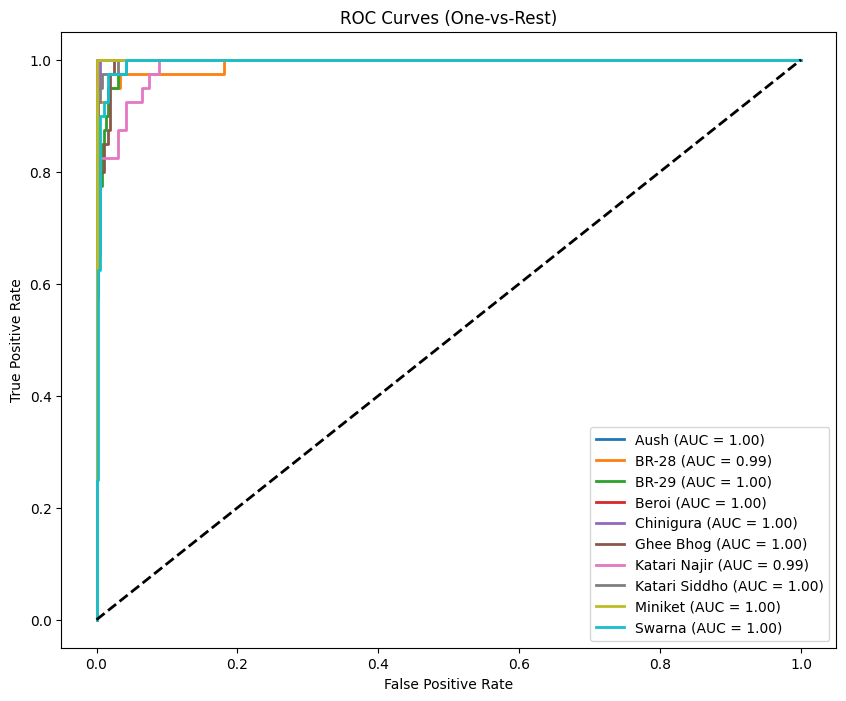

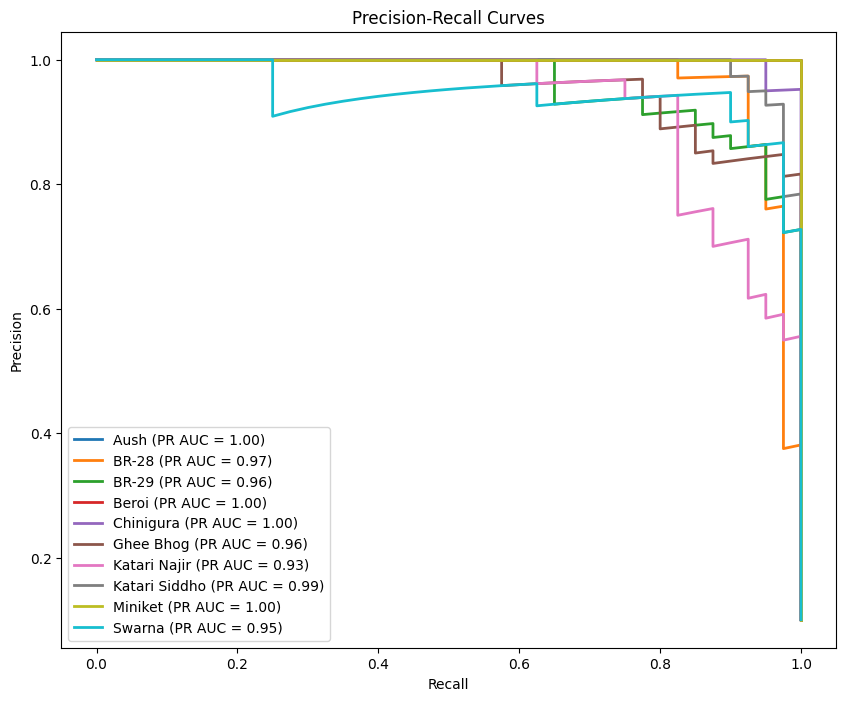

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 16.26 sec
Inference time per sample: 0.040641 sec

Most confused class pairs:
Aush is most often confused with Aush (0 samples)
BR-28 is most often confused with Swarna (2 samples)
BR-29 is most often confused with Katari Najir (4 samples)
Beroi is most often confused with Aush (0 samples)
Chinigura is most often confused with Ghee Bhog (2 samples)
Ghee Bhog is most often confused with Katari Najir (4 samples)
Katari Najir is most often confused with Ghee Bhog (5 samples)
Katari Siddho is most often confused with BR-28 (1 samples)
Miniket is most often confused with BR-28 (1 samples)
Swarna is most often confused with BR-28 (3 samples)


In [12]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data_80_20'
dataset_dir = '/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images'
img_size = (299, 299)
batch_size = 32
num_classes = 10
classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: InceptionV3
# -----------------------------
def build_inception_model(input_shape=(299,299,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

inception_model = build_inception_model(num_classes=num_classes)
inception_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback (only ReduceLROnPlateau)
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = inception_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, inception_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, inception_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, inception_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = inception_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [13]:
start_test = time.time()
_ = inception_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.012644 seconds


In [14]:
# Calculate and print the number of parameters
total_params = inception_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 22,857,002
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Found 1440 images belonging to 10 classes.
Found 160 images belonging to 10 classes.
Found 400 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
45/45 - 33s - 742ms/step - accuracy: 0.2424 - loss: 2.1776 - val_accuracy: 0.3750 - val_loss: 1.8232 - learning_rate: 1.0000e-03
Epoch 2/40
45/45 - 14s - 302ms/step - accuracy: 0.3431 - loss: 1.7836 - val_accuracy: 0.3938 - val_loss: 1.6079 - learning_rate: 1.0000e-03
Epoch 3/40
45/45 - 14s - 318ms/step - accuracy: 0.4222 - loss: 1.5774 - val_accuracy: 0.5625 - val_loss: 1.4536 - learning_rate: 1.0000e-03
Epoch 4/40
45/45 - 14s - 302ms/step - accuracy: 0.4632 - loss: 1.4778 - val_accuracy: 0.4688 - val_loss: 1.4497 - learning_rate: 1.0000e-03
Epoch 5/40
45/45 - 14s - 302ms/step - accuracy: 0.4868 - loss: 1.3939 - val_accuracy: 0.4750 - val_loss: 1.4186 - learning_rate: 1.0000e-03
Epoch 6/40
45/45 - 13s - 300ms/step - accuracy: 0.5028 - loss: 1.3680 - val_accuracy: 0.5188 - val_loss: 1.3271 - learning_rate: 1.0000e-03
Epoch 7/40
45/45 - 15s - 329ms/step - accuracy: 0.5167 - loss: 1.3140 - val_accuracy: 0.5312 - val_loss: 1.3028 - learning_rate: 1.0000e-03
Epoch 8/40
45/45 - 1

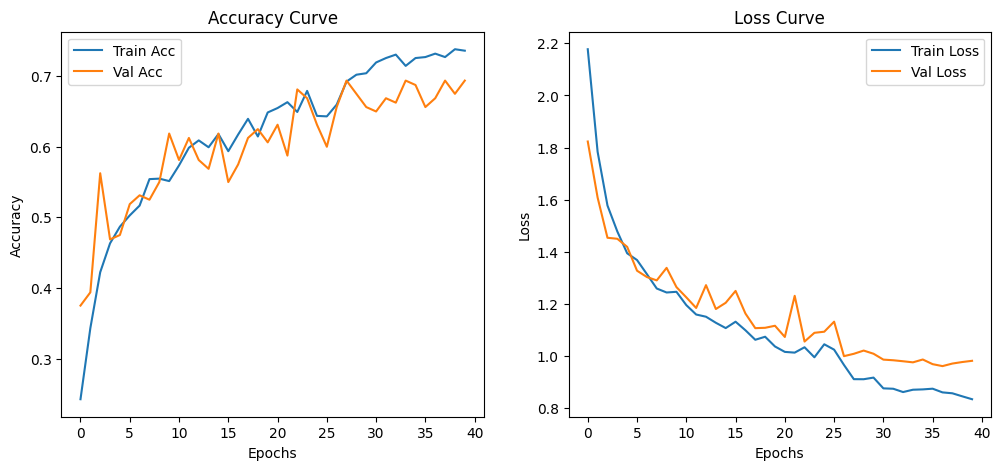


Test Classification Report:
               precision    recall  f1-score   support

         Aush     0.9722    0.8750    0.9211        40
        BR-28     0.8400    0.5250    0.6462        40
        BR-29     0.5000    0.3500    0.4118        40
      Miniket     0.7308    0.9500    0.8261        40
       Swarna     0.9268    0.9500    0.9383        40
 Katari Najir     0.5435    0.6250    0.5814        40
    Ghee Bhog     0.8387    0.6500    0.7324        40
    Chinigura     0.5849    0.7750    0.6667        40
Katari Siddho     0.9268    0.9500    0.9383        40
        Beroi     0.7021    0.8250    0.7586        40

     accuracy                         0.7475       400
    macro avg     0.7566    0.7475    0.7421       400
 weighted avg     0.7566    0.7475    0.7421       400



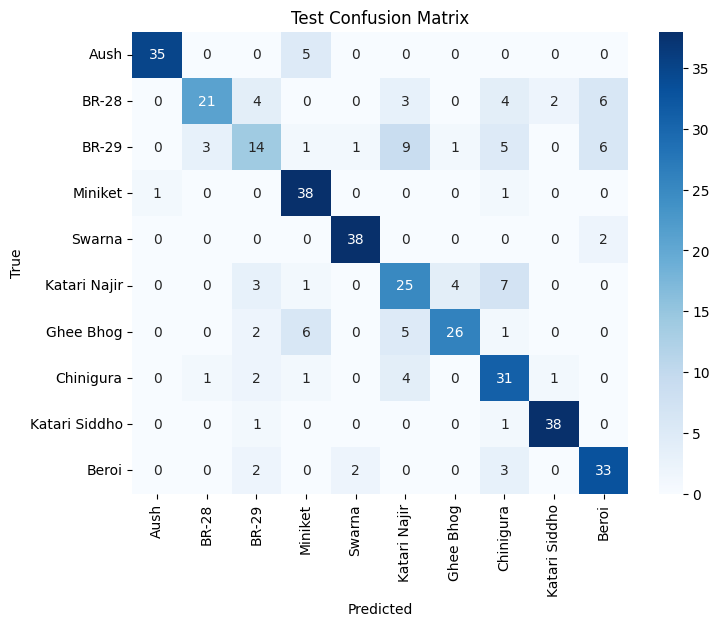

Aush Accuracy: 0.8750
BR-28 Accuracy: 0.5250
BR-29 Accuracy: 0.3500
Miniket Accuracy: 0.9500
Swarna Accuracy: 0.9500
Katari Najir Accuracy: 0.6250
Ghee Bhog Accuracy: 0.6500
Chinigura Accuracy: 0.7750
Katari Siddho Accuracy: 0.9500
Beroi Accuracy: 0.8250
Macro Precision: 0.7566
Macro Recall: 0.7475
Macro F1-score: 0.7421
Aush: Precision=0.9722, Recall=0.8750, F1=0.9211
BR-28: Precision=0.8400, Recall=0.5250, F1=0.6462
BR-29: Precision=0.5000, Recall=0.3500, F1=0.4118
Miniket: Precision=0.7308, Recall=0.9500, F1=0.8261
Swarna: Precision=0.9268, Recall=0.9500, F1=0.9383
Katari Najir: Precision=0.5435, Recall=0.6250, F1=0.5814
Ghee Bhog: Precision=0.8387, Recall=0.6500, F1=0.7324
Chinigura: Precision=0.5849, Recall=0.7750, F1=0.6667
Katari Siddho: Precision=0.9268, Recall=0.9500, F1=0.9383
Beroi: Precision=0.7021, Recall=0.8250, F1=0.7586


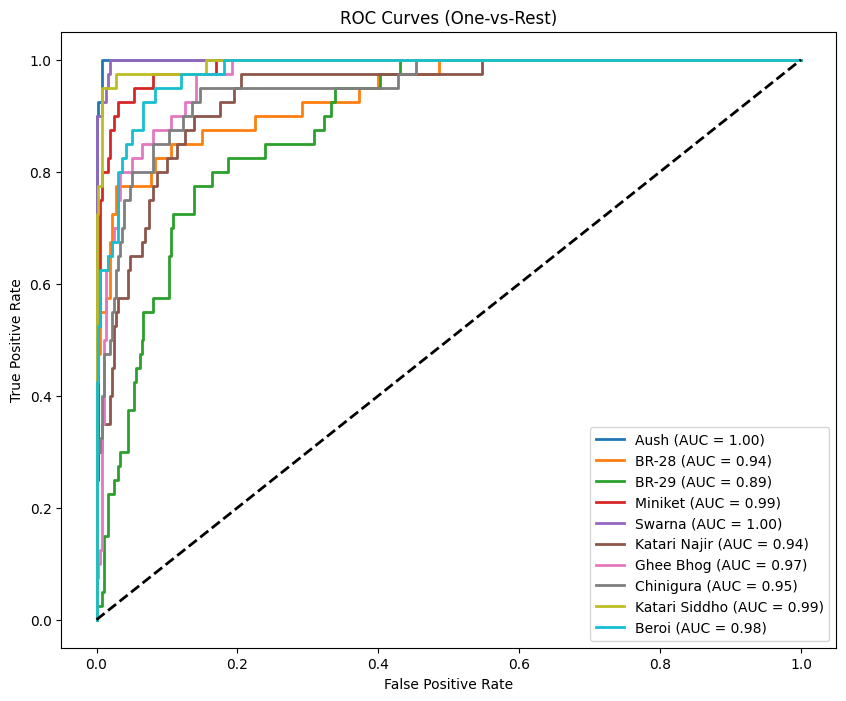

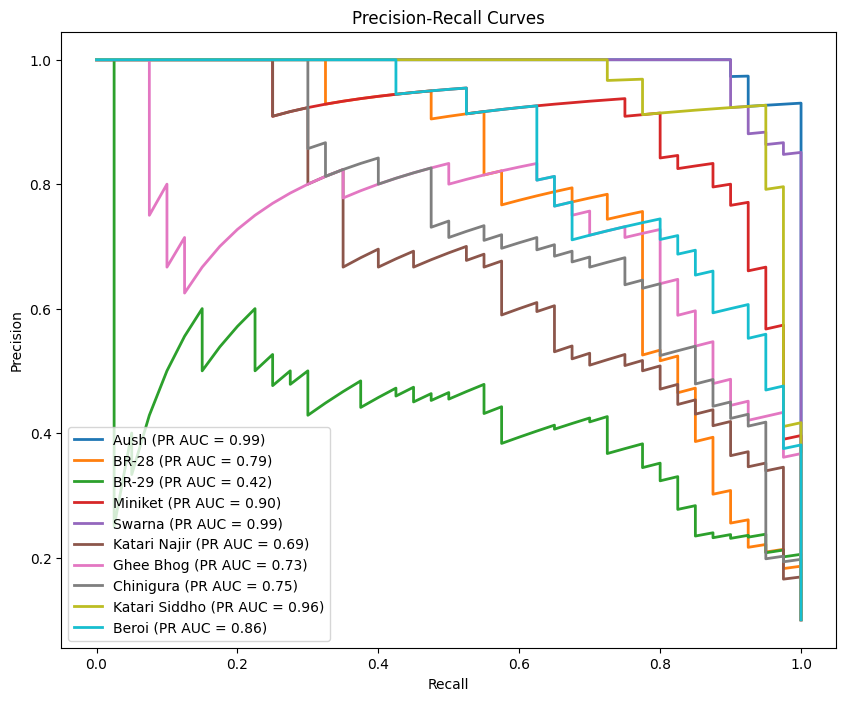

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 11.63 sec
Inference time per sample: 0.029084 sec

Most confused class pairs:
Aush is most often confused with Miniket (5 samples)
BR-28 is most often confused with Beroi (6 samples)
BR-29 is most often confused with Katari Najir (9 samples)
Miniket is most often confused with Aush (1 samples)
Swarna is most often confused with Beroi (2 samples)
Katari Najir is most often confused with Chinigura (7 samples)
Ghee Bhog is most often confused with Miniket (6 samples)
Chinigura is most often confused with Katari Najir (4 samples)
Katari Siddho is most often confused with BR-29 (1 samples)
Beroi is most often confused with Chinigura (3 samples)


In [18]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data_80_20'
dataset_dir = '/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: ResNet50
# -----------------------------
def build_resnet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

resnet_model = build_resnet_model(num_classes=num_classes)
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true, y_pred_prob = [], []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, resnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, resnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, resnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision–Recall Curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Inference time
# -----------------------------
start_infer = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [19]:
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.009479 seconds


In [20]:
# Calculate and print the number of parameters
total_params = resnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 24,641,930
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Found 1440 images belonging to 10 classes.
Found 160 images belonging to 10 classes.
Found 400 images belonging to 10 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
45/45 - 54s - 1s/step - accuracy: 0.5889 - loss: 1.2207 - val_accuracy: 0.8500 - val_loss: 0.6316 - learning_rate: 1.0000e-03
Epoch 2/40
45/45 - 14s - 309ms/step - accuracy: 0.7972 - loss: 0.6076 - val_accuracy: 0.8375 - val_loss: 0.5178 - learning_rate: 1.0000e-03
Epoch 3/40
45/45 - 14s - 306ms/step - accuracy: 0.8521 - loss: 0.4672 - val_accuracy: 0.8813 - val_loss: 0.3829 - learning_rate: 1.0000e-03
Epoch 4/40
45/45 - 15s - 334ms/step - accuracy: 0.8646 - loss: 0.4236 - val_accuracy: 0.8938 - val_loss: 0.3736 - learning_rate: 1.0000e-03
Epoch 5/40
45/45 - 14s - 308ms/step - accuracy: 0.8875 - loss: 0.3470 - val_accuracy: 0.9438 - val_loss: 0.2811 - learning_rate: 1.0000e-03
Epoch 6/40
45/45 - 14s - 313ms/step - accuracy: 0.9062 - loss: 0.3048 - val_accuracy: 0.8750 - val_loss: 0.3241 - learning_rate: 1.0000e-03
Epoch 7/40
45/45 - 14s - 305ms/step - accuracy: 0.9049 - loss: 0.2815 - val_accuracy: 0.8813 - val_loss: 0.3367 - learning_rate: 1.0000e-03
Epoch 8/40
45/45 - 14s 

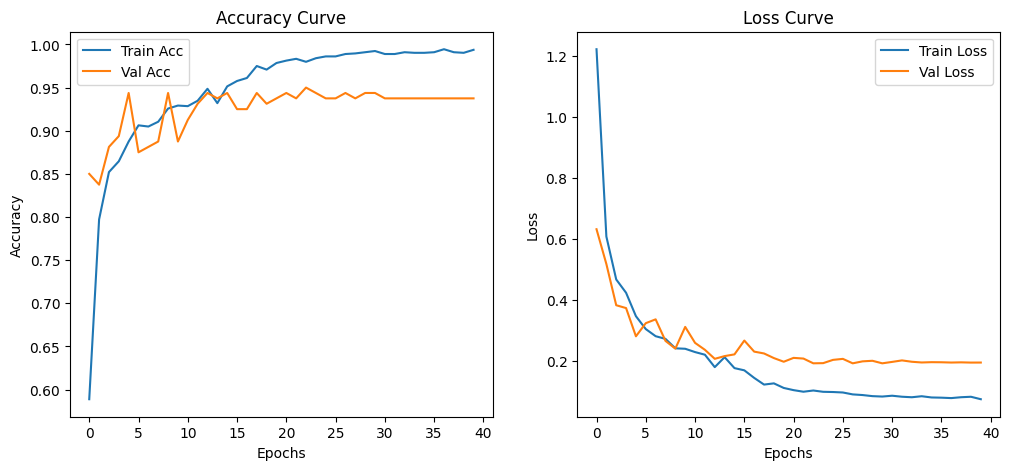


Test Classification Report:
               precision    recall  f1-score   support

         Aush     1.0000    0.9750    0.9873        40
        BR-28     0.9048    0.9500    0.9268        40
        BR-29     0.9211    0.8750    0.8974        40
      Miniket     0.9756    1.0000    0.9877        40
       Swarna     1.0000    1.0000    1.0000        40
 Katari Najir     0.9722    0.8750    0.9211        40
    Ghee Bhog     0.8571    0.9000    0.8780        40
    Chinigura     0.9091    1.0000    0.9524        40
Katari Siddho     1.0000    0.9750    0.9873        40
        Beroi     0.9231    0.9000    0.9114        40

     accuracy                         0.9450       400
    macro avg     0.9463    0.9450    0.9449       400
 weighted avg     0.9463    0.9450    0.9449       400



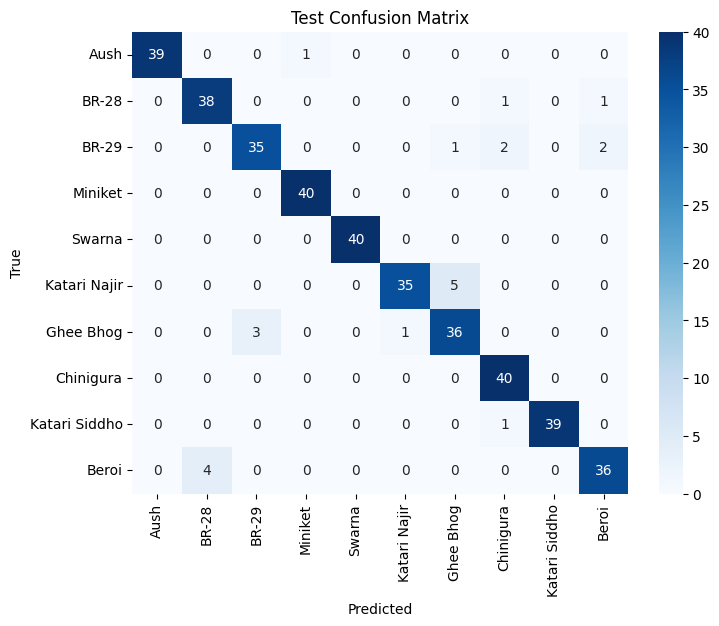

Aush Accuracy: 0.9750
BR-28 Accuracy: 0.9500
BR-29 Accuracy: 0.8750
Miniket Accuracy: 1.0000
Swarna Accuracy: 1.0000
Katari Najir Accuracy: 0.8750
Ghee Bhog Accuracy: 0.9000
Chinigura Accuracy: 1.0000
Katari Siddho Accuracy: 0.9750
Beroi Accuracy: 0.9000


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 27.01 sec
Inference time per sample: 0.067516 sec


In [21]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data_80_20'
dataset_dir = '/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images'
img_size = (224, 224)  # DenseNet121 default input
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: DenseNet121
# -----------------------------
def build_densenet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

densenet_model = build_densenet_model(num_classes=num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, densenet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, densenet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, densenet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")


In [23]:
# Calculate and print the number of parameters
total_params = densenet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 7,567,434
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Macro Precision: 0.9463
Macro Recall: 0.9450
Macro F1-score: 0.9449

Per-Class Metrics:
Aush: Precision=1.0000, Recall=0.9750, F1=0.9873
BR-28: Precision=0.9048, Recall=0.9500, F1=0.9268
BR-29: Precision=0.9211, Recall=0.8750, F1=0.8974
Miniket: Precision=0.9756, Recall=1.0000, F1=0.9877
Swarna: Precision=1.0000, Recall=1.0000, F1=1.0000
Katari Najir: Precision=0.9722, Recall=0.8750, F1=0.9211
Ghee Bhog: Precision=0.8571, Recall=0.9000, F1=0.8780
Chinigura: Precision=0.9091, Recall=1.0000, F1=0.9524
Katari Siddho: Precision=1.0000, Recall=0.9750, F1=0.9873
Beroi: Precision=0.9231, Recall=0.9000, F1=0.9114


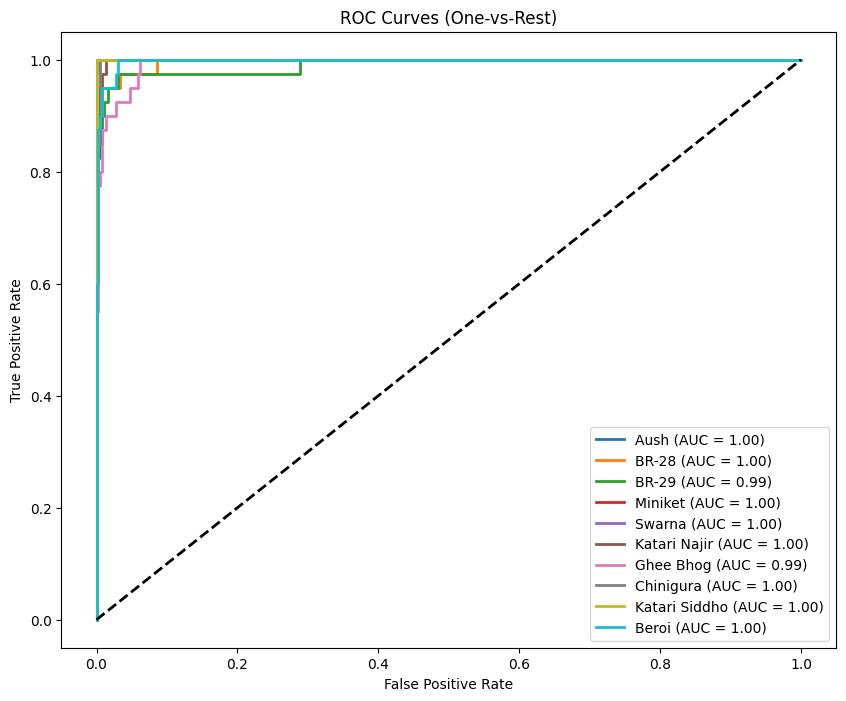

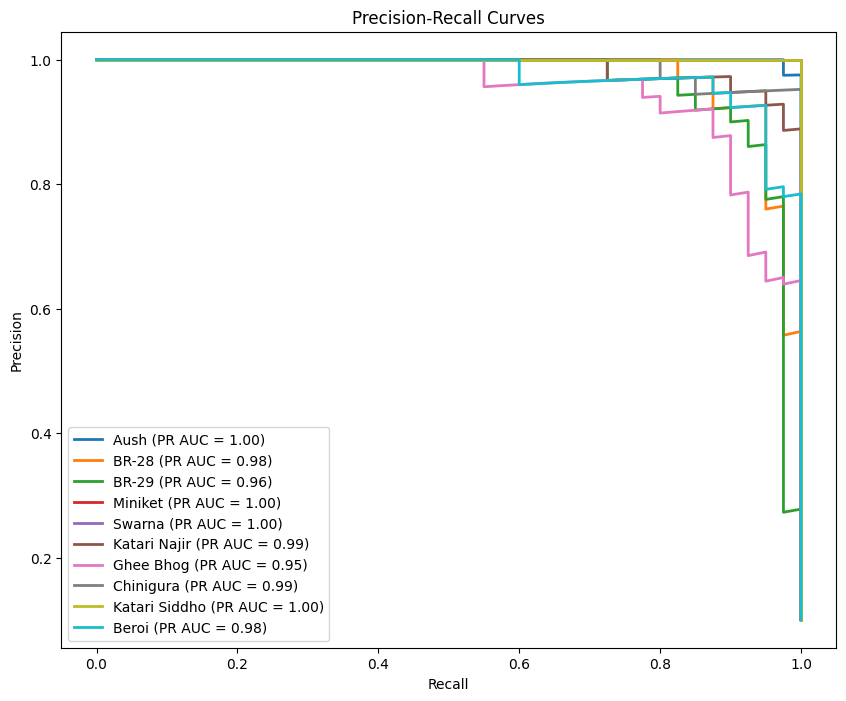


Most Confused Class Pairs:
Aush is most often confused with Miniket (1 samples)
BR-28 is most often confused with Chinigura (1 samples)
BR-29 is most often confused with Chinigura (2 samples)
Miniket is most often confused with Aush (0 samples)
Swarna is most often confused with Aush (0 samples)
Katari Najir is most often confused with Ghee Bhog (5 samples)
Ghee Bhog is most often confused with BR-29 (3 samples)
Chinigura is most often confused with Aush (0 samples)
Katari Siddho is most often confused with Chinigura (1 samples)
Beroi is most often confused with BR-28 (4 samples)


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}\n")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

print("Per-Class Metrics:")
for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC Curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision-Recall Curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Failure Modes: Most Confused Class Pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost Confused Class Pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # Ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")
